### Решающее дерево для решения задачи классификации вин

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets, metrics, tree
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from mlxtend.plotting import plot_decision_regions


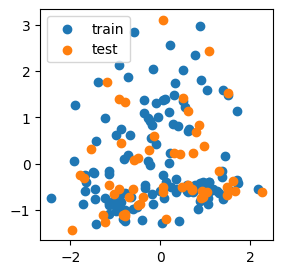

In [2]:
#загружаем датасет, нормализуем и делим на обучающую и тестовую выборки
dataset = datasets.load_wine()

X = StandardScaler().fit_transform(dataset.data)
Y = dataset.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
plt.figure(figsize=(3, 3))
plt.scatter(X_train[:, 0], X_train[:, 1], label="train")
plt.scatter(X_test[:, 0], X_test[:, 1], label="test")
plt.legend()

In [3]:
#выбираем количество важных признаков

from sklearn import decomposition

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca)])
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components)

clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, Y)

print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])

Best Number Of Components: 7


In [4]:
#выбираем важные признаки и удаляем остальные

model_pca = decomposition.PCA(clf_GS.best_estimator_.get_params()['pca__n_components'])
model_pca.fit(X_train)
X_train = model_pca.transform(X_train)
X_test = model_pca.transform(X_test)

In [5]:
#подбираем гиперпараметры для модели
from sklearn import decomposition

dec_tree = DecisionTreeClassifier()
pca = decomposition.PCA()

pipe = Pipeline(steps=[('dec_tree', dec_tree)])

criterion = ['gini', 'entropy','log_loss']
max_depth = [2,3,4,5,6,7,8]
parameters = dict(dec_tree__criterion=criterion,
                    dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, Y)

cr = clf_GS.best_estimator_.get_params()['dec_tree__criterion']
max_d = clf_GS.best_estimator_.get_params()['dec_tree__max_depth']

print('Best Criterion:', cr)
print('Best max_depth:', max_d)

Best Criterion: entropy
Best max_depth: 2


In [6]:
#Обучаем модель с полученными гиперпараметрами 

model = DecisionTreeClassifier(criterion = cr, max_depth=max_d)

#Оцениваем метрики на тестовой выборке
scores = []
model.fit(X_train, Y_train)
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.91      0.95        22
           2       1.00      1.00      1.00        13

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.97      0.96      0.96        54



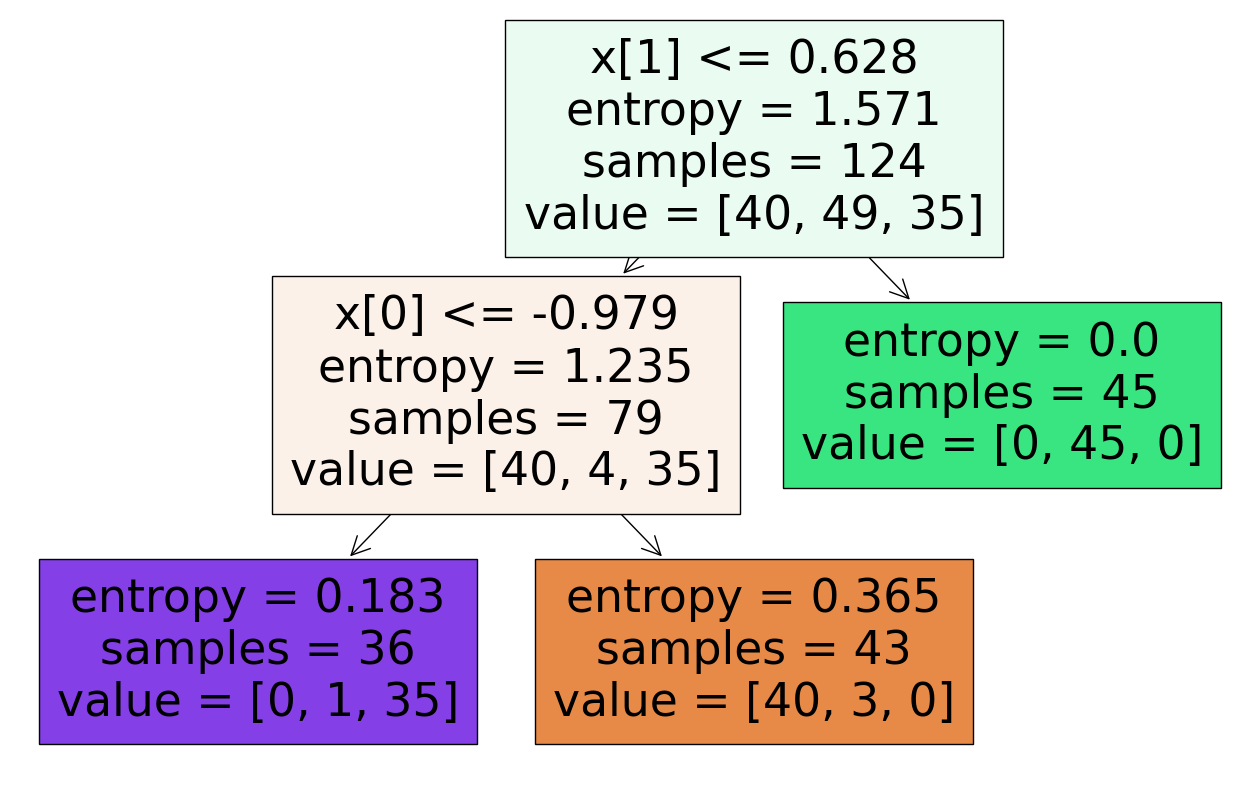

In [7]:
#Визуализируем дерево

fig = plt.figure(figsize=(16,10))
_ = tree.plot_tree(model, filled=True)

In [8]:
#Визуализируем границы между классами 

# Задаем параметры
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

arr = [0] * 6
for i in range(6): 
    arr[i] = [0] * 2
    arr[i][1] = i+1

<AxesSubplot: >

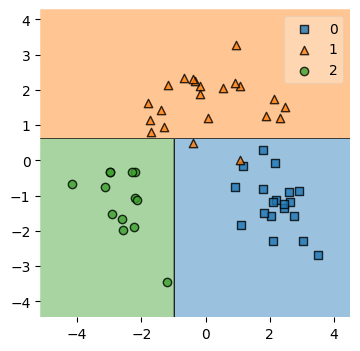

In [9]:
#для первой пары признаков

fig = plt.figure(figsize=(4,4))

model = DecisionTreeClassifier(criterion = cr, max_depth=max_d).fit(X_train[:,:2],Y_train)
plot_decision_regions(X_test[:,:2], Y_test, model)

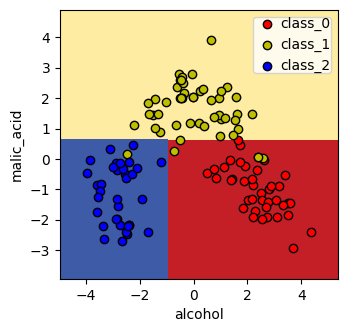

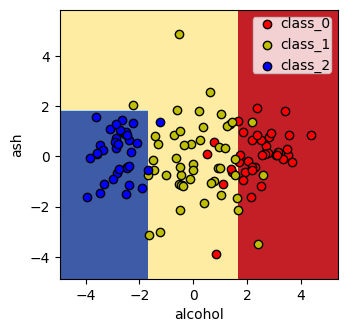

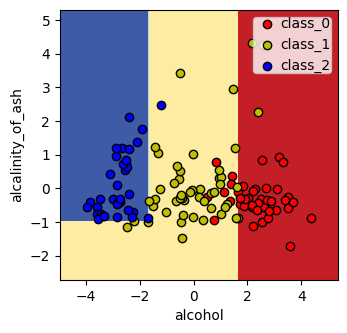

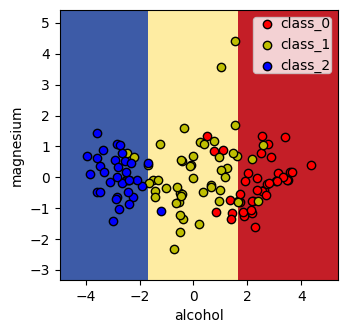

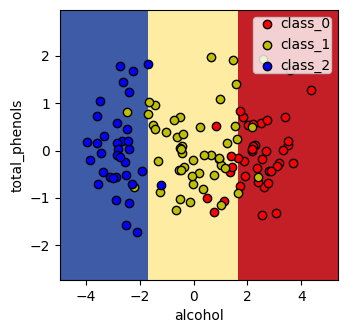

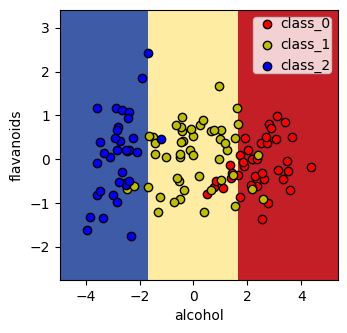

In [10]:
#для других пар признаков

for pairidx, pair in enumerate(arr):
    # Выбираем текущую пару признаков
    X = X_train[:, pair]
    y = Y_train

    # Тренируем модель
    model = DecisionTreeClassifier(criterion = cr, max_depth=max_d).fit(X, y)

    # Изобразим границу классов
    plt.figure(figsize=(6,18))
    plt.subplot(6,2, pairidx + 1)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.9, w_pad=0.1, pad=0)

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(dataset.feature_names[pair[0]])
    plt.ylabel(dataset.feature_names[pair[1]])

    # Визуализация
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=dataset.target_names[i],
            edgecolor="black" 
        )
        plt.legend(loc="upper right", borderpad=0, handletextpad=0)
